## **Notebook #8 - Parte 1**
## Interpretability on convolutional neural networks when solving the MNIST classification problem.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**

### Installing the main packages
**Please, remember to execute [Restart runtime], as required.**

In [1]:
!pip install innvestigate
!pip install scipy==1.1.0
!pip install git+https://github.com/raghakot/keras-vis.git -U
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 1.8 MB/s 
     |████████████████████████████████| 312 kB 8.1 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 132 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstal

In [2]:
# Loading the main libraries
%tensorflow_version 1.x  # utiliza a versão 1.x já presente no Colab

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import innvestigate
import keras

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # utiliza a versão 1.x já presente no Colab`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


Using TensorFlow backend.


### Training the convolutional neural network for the classification task.

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train, x_test = x_train / 255.0, x_test / 255.0
model =keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
activation='relu',input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
model.get_config()
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32)
evaluation = model.evaluate(x_test, y_test)
model.save('mnist_model.h5')

11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/5
60000/60000 [==============================] - 194s 3ms/step - loss: 0.2031 - accuracy: 0.9393
Epoch 2/5
60000/60000 [==============================] - 191s 3ms/step - loss: 0.0830 - accuracy: 0.9750
Epoch 3/5
60000/60000 [==============================] - 190s 3ms/step - loss: 0.0633 - accuracy: 0.9807
Epoch 4/5
60000/60000 [==============================] - 190s 3ms/step - loss: 0.0510 - accuracy: 0.9846
Epoch 5/5
10000/10000 [==============================] - 7s 717us/step


### Applying the proposed methods of explanation

Once our network has been trained, let's apply the following explanation methods: Gradient, SmoothGrad, DeepTaylor, LRPAlphaBeta, LRPEpsilon, LRPZ. The first two are sensitivity approaches and the others are based on LRP.
We will apply each method to 6 test set images from 3 different classes (two images per class, classes = {1, 8, 5}).

For LREpsilon, we chose epsilon equal to 0.25 as done by Montavon et al. (2019), who also show how the DeepTaylor method can result in almost all LRP methods by choosing the expansion reference point appropriately. In the case of the innvestigate library, the reference point was chosen to allow it to also have the positivity property, thus being equivalent to the LRPAlphaBeta method with alpha=1 and beta=0. We will then use these parameters for LRPAlphaBeta and compare their results with those of DeepTaylor.




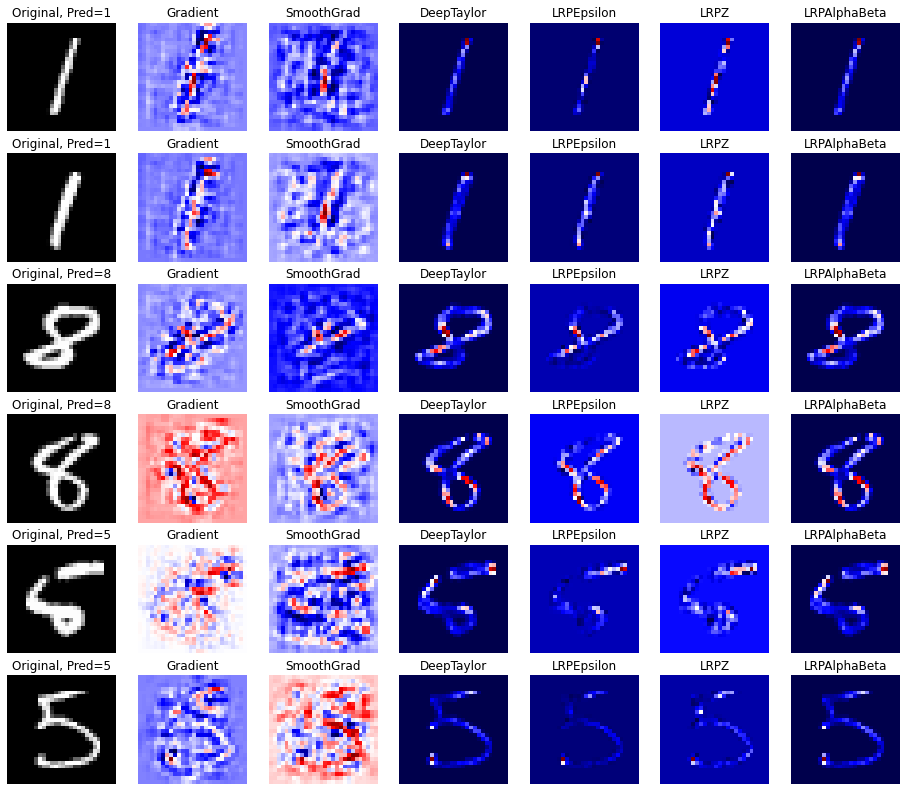

In [4]:
model_wo_sm = innvestigate.utils.keras.graph.model_wo_softmax(model)

classes = [1, 8, 5]
images_j = []
for i in classes:
  k=0
  for j in range(x_test.shape[0]):
    if y_test[j]==i:
      k=k+1
      images_j.append(j)
    if k == 2:
      break 

grad = {'a': innvestigate.analyzer.Gradient(model=model_wo_sm), 'name': 'Gradient'}
smooth_grad = {'a': innvestigate.analyzer.SmoothGrad(model=model_wo_sm), 'name': 'SmoothGrad'}
deep_taylor = {'a': innvestigate.analyzer.DeepTaylor(model=model_wo_sm), 'name': 'DeepTaylor'}
lrpe = {'a': innvestigate.analyzer.LRPEpsilon(model=model_wo_sm,
epsilon=0.25), 'name': 'LRPEpsilon'}
lrpz = {'a': innvestigate.analyzer.LRPZ(model=model_wo_sm), 'name': 'LRPZ'}
lrpab = {'a': innvestigate.analyzer.LRPAlphaBeta(model=model_wo_sm,alpha=1,beta=0), 'name': 'LRPAlphaBeta'}
analyzers = [grad, smooth_grad, deep_taylor, lrpe, lrpz, lrpab]

fig, axs = plt.subplots(2*len(classes), len(analyzers)+1, figsize=(16, 14))
for j in range(2*len(classes)):
  image = x_test[images_j[j]:images_j[j]+1]
  axs[j,0].imshow(image.squeeze(), cmap='gray', interpolation='nearest')
  axs[j,0].set_title("Original, Pred="+str(np.argmax(model.predict(image))))
  axs[j,0].axis('off')
  for i in range(len(analyzers)):
    analysis = analyzers[i]['a'].analyze(image)
    axs[j,i+1].imshow(analysis.squeeze(), cmap='seismic',
    interpolation='nearest')
    axs[j,i+1].set_title(analyzers[i]['name'])
    axs[j,i+1].axis('off')

plt.show()

**(a)Notebook [Ativ8_LRP_MNIST_P1.ipynb]: Utilize a biblioteca innvestigate [1]
para analisar as predições da rede neural, comparando diferentes métodos de
explicação, como: Gradient, SmoothGrad, DeepTaylor, LRPAlphaBeta,
LRPEpsilon, LRPZ. O notebook toma 6 mapas de calor de 3 classes distintas (2
imagens por classe) para analisar. O que se busca responder com esses mapas de
calor? Interprete os resultados.**

R: Os mapas de calor buscam mostrar a estratégia adotada pela máquina para classificar corretamente os valores, podemos observar nas imagens as áreas de ativação de cada método. Em geral todos os métodos obtem classificações competentes a respeito dos modelos, com exceção dos métodos <i>Gradient</i> e <i>SmoothGrad</i>, que apresentam modelos "poluídos", com muita informação desnecessária para realizar a classificação.
Vale a pena mencionar que os métodos (com exceção dos métodos de Gradiente) produzem boas representações do moodelo de apredizado, podemos observar que, para o dígito 8 por exemplo, as áreas próximas da curva (em vermelho) são mais importantes para a classificação correta do dígito, pois é ai que ele mais se difere dos outros dígitos, resultando em uma maior ativação.

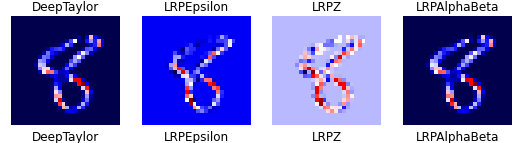